# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 3 - Bayesian Analysis



**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner 


<hr style="height:2pt">

### Homework 3 is due March 5th

In [1]:
#PLEASE RUN THIS CELL
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline 
from datetime import datetime as dt
from scipy.special import expit


<hr style="height:2pt">

### Contraceptive Usage by Bangladeshi Women

In the second part of this assignment, you are provided with data sets `dataset_2_train.csv` and `dataset_2_test.csv`containing details of contraceptive usage by 1934 Bangladeshi women. There are four attributes for each woman, along with a label indicating if she uses contraceptives. The attributes include
* district: identifying code for the district the woman lives in
* urban: type of region of residence
* living.children: number of living children
* age-mean: age of the woman (in years, centered around mean)

The women are grouped into 60 districts. The task is to build a classification model that can predict if a given woman uses contraceptives.


### Part A: Bayesian Logistic Regression

The first model we will fit to the contraceptives data is a varying-intercept logistic regression model, where the intercept varies by district.

Prior distribution:

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)$.

$\beta_1 \sim N(0,10000)$, $\beta_2\sim N(0,10000)$, $\beta_3 \sim N(0,10000)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}$,

where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

##### **A1**

As a preprocessing step, map the district number 61 to the number 54 so that the districts are in order. Also, re-name district 60 to be district 0 so that the districts are numbered 0 through 59. **We use this numbering throughout the homework, and will grade using these district numbers**

In [3]:
#your code here
train_df = pd.read_csv("../data/dataset_2_train.csv");
test_df = pd.read_csv("../data/dataset_2_test.csv");
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 5 columns):
district             967 non-null int64
urban                967 non-null int64
living.children      967 non-null int64
age_mean             967 non-null float64
contraceptive_use    967 non-null int64
dtypes: float64(1), int64(4)
memory usage: 37.9 KB


,district,urban,living.children,age_mean,contraceptive_use
count,967.000000,967.000000,967.000000,967.000000,967.000000
mean,29.680455,0.307135,2.591520,-0.310626,0.389866
std,17.713976,0.461545,1.248457,8.995747,0.487972
min,1.000000,0.000000,1.000000,-13.560000,0.000000
25%,14.000000,0.000000,1.000000,-7.560000,0.000000
50%,29.000000,0.000000,3.000000,-1.559900,0.000000
75%,46.000000,1.000000,4.000000,6.440000,1.000000
max,61.000000,1.000000,4.000000,19.440000,1.000000


In [4]:
train_df['district'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 55, 56, 57, 58, 59, 60, 61])

In [5]:
train_df['district'].replace({61:54, 60:0}, inplace=True)
train_df.rename(columns = {"living.children":"living_children"}, inplace = True) 
test_df['district'].replace({61:54, 60:0}, inplace=True)
test_df.rename(columns = {"living.children":"living_children"}, inplace = True) 

In [6]:
train_df['district'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

In [7]:
train_df.head()

,district,urban,living_children,age_mean,contraceptive_use
0,35,0,4,2.4400,0
1,22,0,2,-1.5599,1
2,29,0,2,-8.5599,1
3,5,0,3,-4.5599,1
4,34,1,4,8.4400,0


##### **A2**

First, we'll verify that pymc3 can recover the hidden parameter values. To do so, we'll hard-code known values and simulate data from the model, then using that data we'll check if pymc3 can get back the parameters we hard-coded. If it does, we'll have hope that it can get the hidden parameter values that generated the real data.

Use the following hard-coded values:  
$\mu_0 = 2$

$\sigma^2_0 = 1$

$\beta_{0j} \sim N(\mu_0,\sigma_0^2)$ for all sixty districts

$\beta_1 = 4$

$\beta_2 = -3$

$\beta_3 = -2$

**Verify that these parameters give an overall average of 46 to 48 percent of subjects using contraceptives**

The urban mean is 0.30713547052740436
The living_children mean is 2.591520165460186
The age_mean mean is  -0.31062595656670683
The current contraceptive_use mean is 0.38986556359875907
The calculated contraceptive_use mean is 0.4700359482354283
The new contraceptive_use mean is 0.47156153050672184


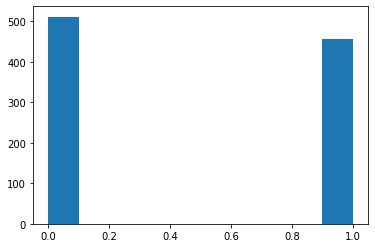

In [8]:
#your code here
np.random.seed(50) #use this seed tto generate the same results

print('The urban mean is', train_df['urban'].mean())
print('The living_children mean is', train_df['living_children'].mean())
print('The age_mean mean is ', train_df['age_mean'].mean())
print('The current contraceptive_use mean is', train_df['contraceptive_use'].mean())
print('The calculated contraceptive_use mean is', expit(2 + 4*.34 + -3*1 + -2*.24))

mu, sigma = 2, 1
beta = [4, -3, -2]
# try with all simulated data
alpha = np.random.normal(mu,sigma, 60)


colNames = ('district', 'beta0','urban', 'living_children', 'age_mean', 'contraceptive_use')
sim_df = pd.DataFrame(columns = colNames)
d = 0
for  i in  alpha:
  a = train_df.loc[train_df['district'] == d]
  size = len(a)
  X1 = np.random.binomial(1,0.307, size)
  X2 = (np.random.normal(2.49,1.2, size)).astype(int)
  X3 = np.random.normal(-0.41,9,size)
  pi = expit(i + beta[0]*X1 + beta[1]*X2 + beta[2]*X3 + np.random.randn(size)*sigma)
  j = pi
  #np.set_printoptions(formatter={'float_kind':'{:f}'.format})
  Y = np.random.binomial(1,j)
  temp_df = pd.DataFrame(columns = colNames)
  temp_df['urban'] = X1.astype(float)
  temp_df['living_children'] = X2.astype(float)
  temp_df['age_mean'] = X3   
  temp_df['contraceptive_use'] =Y 
  temp_df['district'] = d 
  temp_df['district'] = temp_df['district']
  temp_df['beta0'] = i
  sim_df = sim_df.append(temp_df) 
  d = d+1

sim_df['district'] = sim_df['district'].astype(int)
sim_df['contraceptive_use'] = sim_df['contraceptive_use'].astype(int)

print('The new contraceptive_use mean is',np.mean(sim_df['contraceptive_use']))

plt.hist(sim_df['contraceptive_use'])
plt.show()


<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Qa2
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>You could have also used the given data instead of simulating. Also, please label your histogram in the next homework.</span></div></div>

##### **A3**

Fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested in pymc3's warnings.

Note: It is wise to take advantage of a model's built-in `summary` method to inspect it after fitting

In [9]:
#your code here

with pm.Model() as contraceptive_model:
    mu = pm.Normal('mu', mu=0, sigma=10000)
    sigma = pm.Gamma('sigma', alpha=0.1, beta=0.1)
    
    beta0 = pm.Normal('beta0', mu=mu, sigma=sigma, shape=len(np.unique(sim_df['district'])))[sim_df['district']]
    beta1 = pm.Normal('beta1', mu=0, sigma=10000)
    beta2 = pm.Normal('beta2', mu=0, sigma=10000)
    beta3 = pm.Normal('beta3', mu=0, sigma=10000)
    
    P_i = pm.Deterministic('$P_i$', pm.math.invlogit(beta0 + beta1*sim_df['urban'] + beta2*sim_df['living_children'] + beta3*sim_df['age_mean']))
    
    obs = pm.Bernoulli('obs', p=P_i, shape=len(sim_df), observed=sim_df['contraceptive_use'])
    
    trace = pm.sample(2000, tune=500, target_accept=0.98)
    
pm.summary(trace, var_names=['mu', 'sigma', 'beta0', 'beta1', 'beta2', 'beta3'])


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta3, beta2, beta1, beta0, sigma, mu]
/usr/share/anaconda3/lib/python3.7/site-p

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,1.778,0.468,0.932,2.686,0.043,0.030,119.0,119.0,111.0,162.0,1.10
sigma,0.379,0.338,0.005,0.982,0.104,0.076,11.0,11.0,6.0,21.0,1.29
beta0[0],1.609,0.657,0.336,2.829,0.046,0.032,206.0,206.0,177.0,302.0,1.14
beta0[1],1.733,0.593,0.578,2.879,0.039,0.028,227.0,227.0,192.0,465.0,1.13
beta0[2],1.617,0.636,0.446,2.891,0.043,0.030,220.0,220.0,163.0,465.0,1.13
...,...,...,...,...,...,...,...,...,...,...,...
beta0[58],1.669,0.617,0.382,2.848,0.041,0.029,221.0,221.0,185.0,436.0,1.12
beta0[59],1.796,0.687,0.469,3.042,0.044,0.031,243.0,243.0,194.0,509.0,1.12
beta1,3.098,0.556,2.104,4.173,0.030,0.021,348.0,348.0,341.0,914.0,1.02
beta2,-2.302,0.317,-2.907,-1.740,0.027,0.019,135.0,135.0,124.0,275.0,1.03


<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Qa3
</span></div>
<div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>You did not sample the sigma from the gamma distribution as asked
</span></div>
<div class='alert alert-block alert-danger'><b>Deduction : </b><span style = 'color:black'>-1</span></div></div>

##### **A4**

Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \sigma_0, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged?

/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc7bb864650>,
      dtype=object)

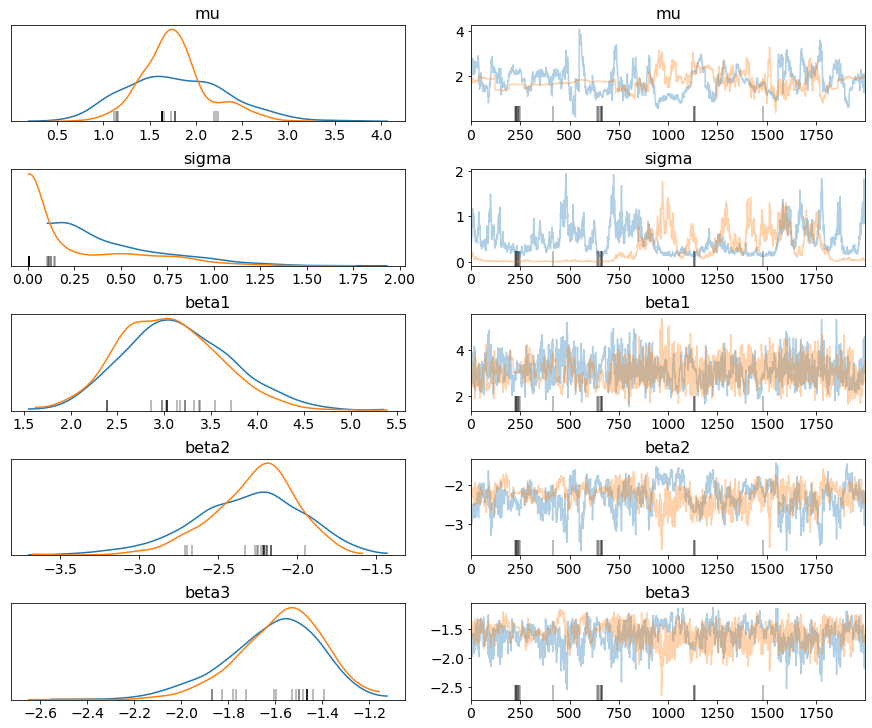

In [10]:
#your code here
pm.traceplot(trace, var_names=('mu', 'sigma', 'beta1', 'beta2', 'beta3'))


your response here<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;">The Bayseian logistic regression model we created to fit our simulated data was close to capturing the hard-coded values within the parameters, $\mu_0, \sigma_0, \beta_1, \beta_2, \beta_3$, distributions of our simulated data. In addition, based on the R-hat values, larger than 1.05, the samplers do not seem to have converged.</p>
<p style="text-indent: 25px;"></p>
</font>

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Qa4
</span></div>
<div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Model is indeed not converged, rhats are too large
</span></div>
<div class='alert alert-block alert-danger'><b>Deduction : </b><span style = 'color:black'>-3</span></div></div>

##### **A5**

Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions? 

/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc7b96f7890>,
      dtype=object)

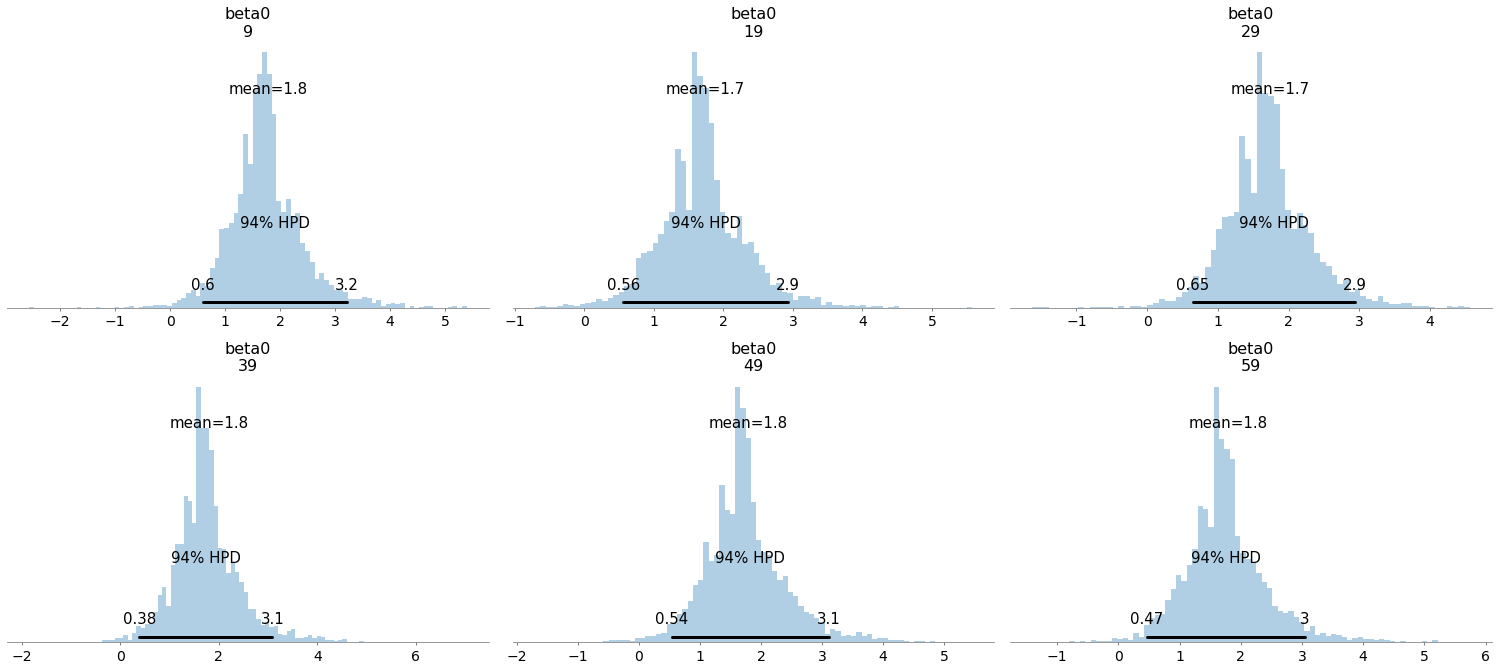

In [11]:
#your code here
#pm.plot_posterior(trace, var_names=('beta0'))
pm.plot_posterior(trace, var_names='beta0', coords={'beta0_dim_0': [9, 19, 29, 39, 49, 59]}, kind='hist')


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


(<Figure size 1440x360 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc7bb975390>],
       dtype=object))

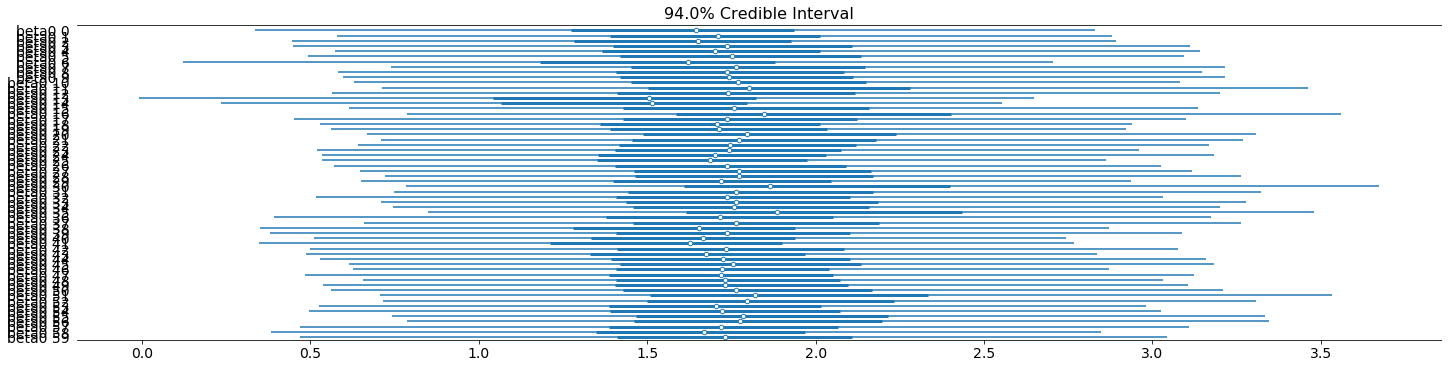

In [12]:
pm.plot_forest(trace,
               kind='forestplot',
               var_names=['beta0'],
               combined=True,
               ridgeplot_overlap=60,
               figsize=(20, 5))


your response here<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;">The posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$ does contain the actual parameters we generated. Most of the means are around 1.7 to 1.8, which is very close to the hard coded value of 2.</p>
<p style="text-indent: 25px;"></p>
</font>

##### **A6**

We now fit our model to the actual data. Fit the varying-intercept model to the real training data.

In [13]:
#your code here

with pm.Model() as contraceptive_model:
    mu = pm.Normal('mu', mu=0, sigma=10000)
    sigma = pm.Gamma('sigma', alpha=0.1, beta=0.1)
    
    beta0 = pm.Normal('beta0', mu=mu, sigma=sigma, shape=len(np.unique(train_df['district'])))[train_df['district']]
    beta1 = pm.Normal('beta1', mu=0, sigma=10000)
    beta2 = pm.Normal('beta2', mu=0, sigma=10000)
    beta3 = pm.Normal('beta3', mu=0, sigma=10000)
    
    P_i = pm.Deterministic('$P_i$', pm.math.invlogit(beta0 + beta1*train_df['urban'] + beta2*train_df['living_children'] + beta3*train_df['age_mean']))
    
    obs = pm.Bernoulli('obs', p=P_i, shape=len(train_df), observed=train_df['contraceptive_use'])

    trace = pm.sample(2000, tune=500, target_accept=0.95)
    
    pm.summary(trace, var_names=['mu', 'sigma', 'beta0', 'beta1', 'beta2', 'beta3'])
    
    print(trace.varnames)    
    print('DONE')


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta3, beta2, beta1, beta0, sigma, mu]
/usr/share/anaconda3/lib/python3.7/site-p

['mu', 'sigma_log__', 'beta0', 'beta1', 'beta2', 'beta3', 'sigma', '$P_i$']
DONE


##### **A7**

Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?

/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6ebaf2f50>,
      dtype=object)

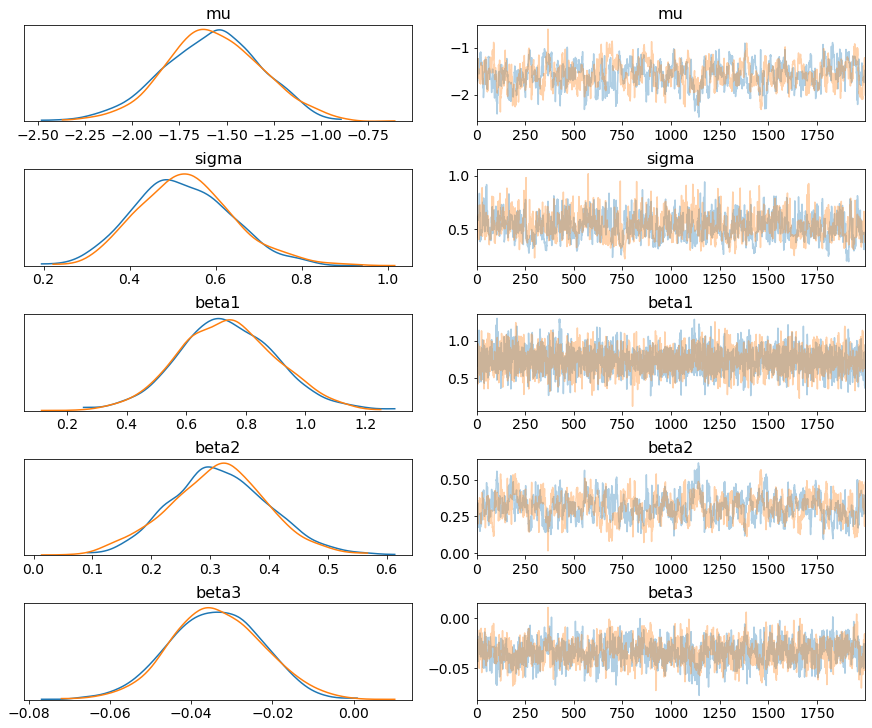

In [14]:
#your code here
pm.traceplot(trace, var_names=('mu', 'sigma', 'beta1', 'beta2', 'beta3'))


In [15]:
pm.summary(trace, var_names=['mu', 'sigma', 'beta1', 'beta2', 'beta3'])


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,-1.578,0.256,-2.044,-1.078,0.015,0.011,278.0,278.0,277.0,465.0,1.0
sigma,0.527,0.113,0.313,0.732,0.005,0.004,516.0,516.0,481.0,581.0,1.0
beta1,0.736,0.163,0.430,1.046,0.004,0.003,2125.0,1880.0,2199.0,2153.0,1.0
beta2,0.314,0.083,0.157,0.470,0.005,0.003,282.0,282.0,281.0,534.0,1.0
beta3,-0.034,0.011,-0.055,-0.013,0.000,0.000,527.0,522.0,529.0,1230.0,1.0


your response here<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;">In this case, using the trainng data, the convergence is actually much better than the simulated data. The beta's converge very well and the R-hats are 1 or nearly 1.</p>
<p style="text-indent: 25px;"></p>
</font>

##### **A8**

Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest?

In [16]:
#your code here
beta0_sum = pm.summary(trace, var_names=['beta0'])
beta0_sum[(beta0_sum['mean']==beta0_sum['mean'].min()) | (beta0_sum['mean']==beta0_sum['mean'].max())]


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta0[11],-2.156,0.526,-3.117,-1.176,0.019,0.013,760.0,760.0,748.0,1980.0,1.0
beta0[56],-0.690,0.417,-1.506,0.081,0.014,0.011,872.0,785.0,863.0,1360.0,1.0


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6e9443b10>,
      dtype=object)

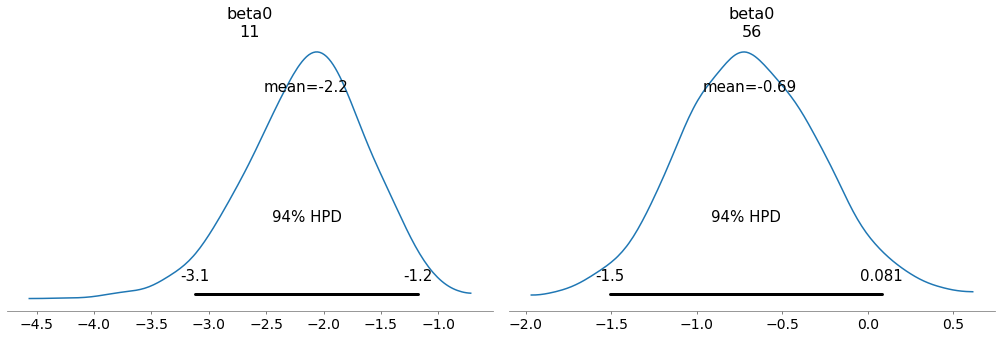

In [17]:
pm.plots.plot_posterior(trace, var_names = 'beta0', coords={'beta0_dim_0': [11, 56]})


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


(<Figure size 1440x360 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc70936c4d0>],
       dtype=object))

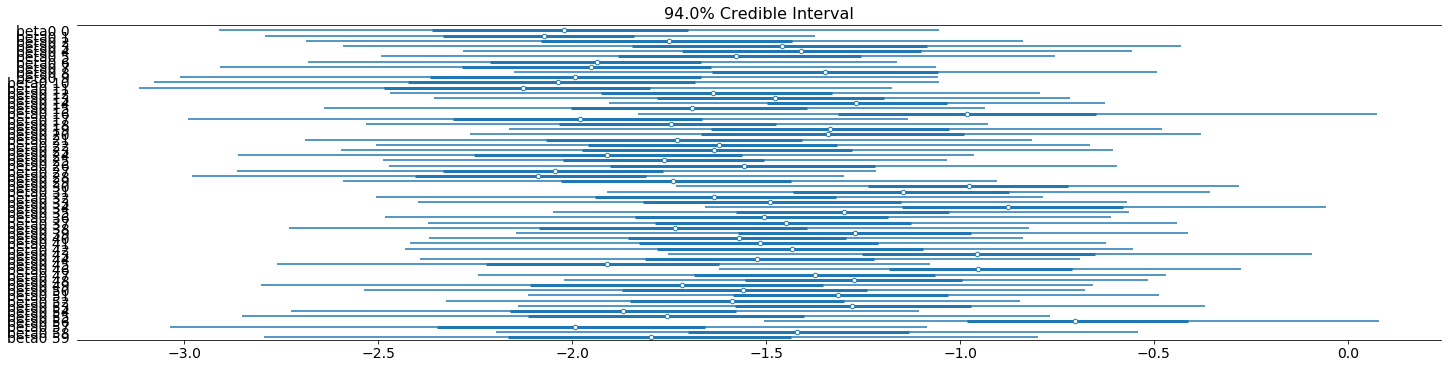

In [18]:
pm.plot_forest(trace,
               kind='forestplot',
               var_names=['beta0'],
               combined=True,
               ridgeplot_overlap=60,
               figsize=(20, 5))


In [19]:
cuse = 0
for d in sorted(train_df.district.unique()):
    distdata = train_df[(train_df['district'] == d)]
    u = (distdata[(distdata['contraceptive_use'] == 1)])
    cuse = cuse + sum(u['contraceptive_use'])
    print('Contraceptive us for district ' + str(d)+": "+str(sum(u['contraceptive_use'])))

Contraceptive us for district 0: 2
Contraceptive us for district 1: 16
Contraceptive us for district 2: 3
Contraceptive us for district 3: 1
Contraceptive us for district 4: 6
Contraceptive us for district 5: 4
Contraceptive us for district 6: 7
Contraceptive us for district 7: 2
Contraceptive us for district 8: 7
Contraceptive us for district 9: 1
Contraceptive us for district 10: 0
Contraceptive us for district 11: 0
Contraceptive us for district 12: 5
Contraceptive us for district 13: 7
Contraceptive us for district 14: 32
Contraceptive us for district 15: 5
Contraceptive us for district 16: 6
Contraceptive us for district 17: 2
Contraceptive us for district 18: 6
Contraceptive us for district 19: 7
Contraceptive us for district 20: 3
Contraceptive us for district 21: 3
Contraceptive us for district 22: 3
Contraceptive us for district 23: 1
Contraceptive us for district 24: 1
Contraceptive us for district 25: 11
Contraceptive us for district 26: 2
Contraceptive us for district 27: 3

your response here<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;">This model gives the lowest contraceptive mean to district 11 and the highest to district 56. The true model has district 11 as one of the district with the lowest usage of contraceptive at 0. District 56 does not have the most usage but rather it is the third highest.</p>
<p style="text-indent: 25px;"></p>
</font>

##### **A9**

What are the posterior means of $\mu_0$ and $\sigma^2_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts or a model with an intercept of 0 for all districts?

In [20]:
#your code here
np.mean(trace['mu']),np.mean(trace['sigma']), np.mean(trace['$P_i$'])


(-1.5781698611563888, 0.5268218958930861, 0.3901253606749566)

your response here<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;">The poseterior mean of $P_i$ is 0.39, which is very close to the mean of the actual data. This is evidence that the varying-intercept model is the correct model.</p>
<p style="text-indent: 25px;"></p>
</font>

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Qa9
</span></div>
<div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Explanation is wrong
</span></div>
<div class='alert alert-block alert-danger'><b>Deduction : </b><span style = 'color:black'>-2</span></div></div>

### Part B: Varying-Coefficients Model

The next model we will fit to the contraceptives data is a varying-coefficients logistic regression model, where the coefficients on living.children, age-mean, and urban vary by district.

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma_0^2} \sim \text{Gamma}(0.1,0.1)$.

$\beta_{1j} \sim N(0,\sigma_1^2)$, with $\frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1)$

$\beta_{2j}\sim N(0,\sigma_2^2)$, with $\frac{1}{\sigma^2_2}\sim \text{Gamma}(0.1,0.1)$

$\beta_{3j} \sim N(0,\sigma_3^2)$, with $\frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}$,

##### **B1**

Fit the model to the real data. Plot posterior means for each of the coefficients to the predictors. What do you conclude from these graphs?

In [21]:
#your code here
with pm.Model() as contraceptive_model:
    mu = pm.Normal('mu', mu=0, sigma=10000)
    
    sigma0 = pm.Gamma('sigma0', alpha=.1, beta=.1)
    sigma1 = pm.Gamma('sigma1', alpha=.1, beta=.1)
    sigma2 = pm.Gamma('sigma2', alpha=.1, beta=.1)
    sigma3 = pm.Gamma('sigma3', alpha=.1, beta=.1)
    
    beta0 = pm.Normal('beta0', mu=mu, sigma=sigma0, shape=len(np.unique(train_df['district'])))[train_df['district']]
    beta1 = pm.Normal('beta1', mu=0, sigma=sigma1, shape=len(np.unique(train_df['district'])))[train_df['district']]
    beta2 = pm.Normal('beta2', mu=0, sigma=sigma2, shape=len(np.unique(train_df['district'])))[train_df['district']]
    beta3 = pm.Normal('beta3', mu=0, sigma=sigma3, shape=len(np.unique(train_df['district'])))[train_df['district']]
    
    p_i = pm.Deterministic('$P_i$', pm.math.invlogit(beta0 + beta1*train_df['urban'] + beta2*train_df['living_children'] + beta3*train_df['age_mean']))
    
    obs = pm.Bernoulli('obs', p=p_i, shape=len(train_df), observed=train_df['contraceptive_use'])
    
    trace = pm.sample(900, tune=600, target_accept=0.95)
    
    print(trace.varnames)    
    print('DONE')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta3, beta2, beta1, beta0, sigma3, sigma2, sigma1, sigma0, mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [06:31<00:00,  7.66draws/s]
/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an

['mu', 'sigma0_log__', 'sigma1_log__', 'sigma2_log__', 'sigma3_log__', 'beta0', 'beta1', 'beta2', 'beta3', 'sigma0', 'sigma1', 'sigma2', 'sigma3', '$P_i$']
DONE


In [22]:
pm.summary(trace, var_names=['mu', 'sigma0', 'sigma1', 'sigma2', 'sigma3'])


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,-0.634,0.117,-0.860,-0.435,0.006,0.004,389.0,389.0,392.0,957.0,1.01
sigma0,0.501,0.145,0.229,0.786,0.027,0.019,29.0,29.0,31.0,34.0,1.07
sigma1,0.717,0.261,0.208,1.176,0.029,0.021,80.0,80.0,75.0,85.0,1.03
sigma2,0.084,0.067,0.003,0.193,0.028,0.020,6.0,6.0,6.0,50.0,1.25
sigma3,0.009,0.008,0.000,0.023,0.002,0.002,11.0,11.0,7.0,21.0,1.22


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f7cf03550>,
      dtype=object)

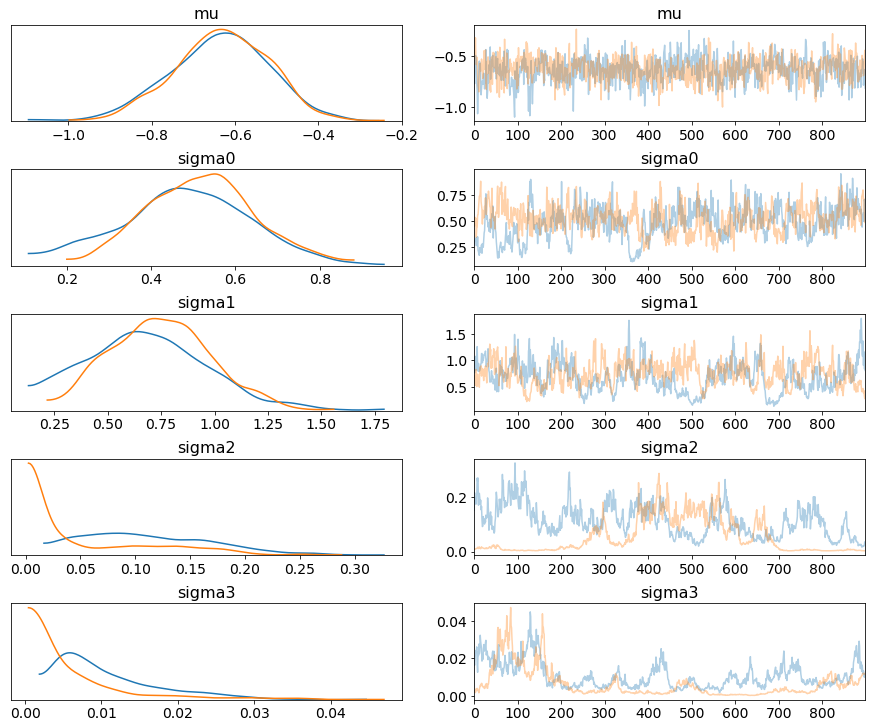

In [23]:
pm.traceplot(trace, var_names=('mu', 'sigma0', 'sigma1', 'sigma2', 'sigma3'))


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


(<Figure size 1440x144 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f7bd1bf10>],
       dtype=object))

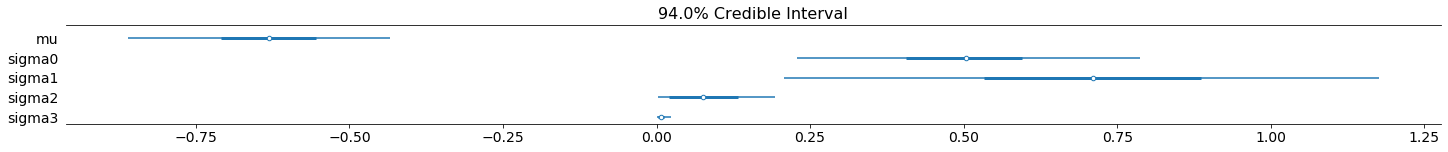

In [24]:
pm.plot_forest(trace,
               kind='forestplot',
               var_names=['mu', 'sigma0', 'sigma1', 'sigma2', 'sigma3'],
               combined=True,
               ridgeplot_overlap=5,
               figsize=(20, 2))

In [25]:
beta0_sum = pm.summary(trace, var_names=['beta0'])
beta0_sum[(beta0_sum['mean']==beta0_sum['mean'].min()) | (beta0_sum['mean']==beta0_sum['mean'].max())]


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta0[11],-1.242,0.495,-2.169,-0.393,0.029,0.020,294.0,293.0,307.0,754.0,1.02
beta0[56],0.109,0.443,-0.708,0.948,0.050,0.035,80.0,80.0,80.0,338.0,1.03


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f7cf60150>,
      dtype=object)

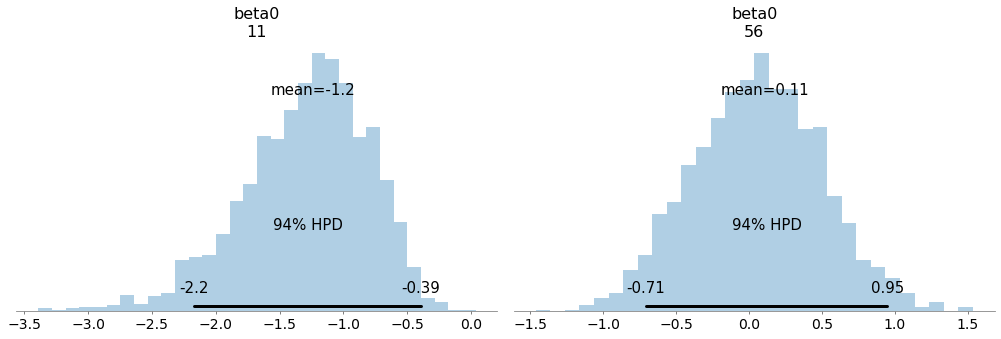

In [26]:
pm.plot_posterior(trace, var_names='beta0', coords={'beta0_dim_0': [11, 56]}, kind='hist')


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


(<Figure size 1440x360 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f7fd1b5d0>],
       dtype=object))

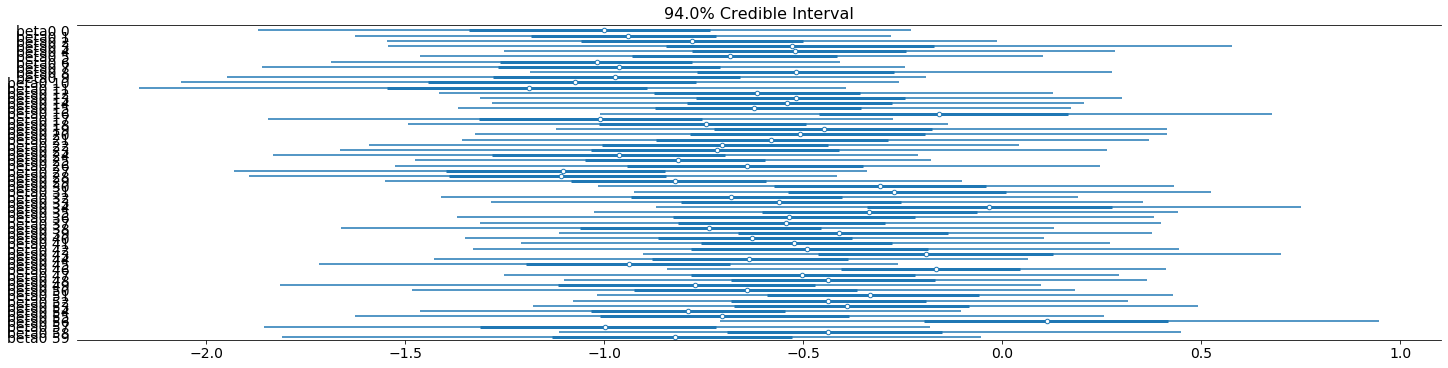

In [27]:
pm.plot_forest(trace,
               kind='forestplot',
               var_names=['beta0'],
               combined=True,
               ridgeplot_overlap=60,
               figsize=(20, 5))


In [28]:
beta1_sum = pm.summary(trace, var_names=['beta1'])
beta1_sum[(beta1_sum['mean']==beta1_sum['mean'].min()) | (beta1_sum['mean']==beta1_sum['mean'].max())]


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta1[14],0.891,0.483,-0.047,1.716,0.033,0.023,215.0,215.0,207.0,922.0,1.01
beta1[52],-0.403,0.536,-1.405,0.610,0.016,0.014,1063.0,750.0,1116.0,1214.0,1.00


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f7f284a10>,
      dtype=object)

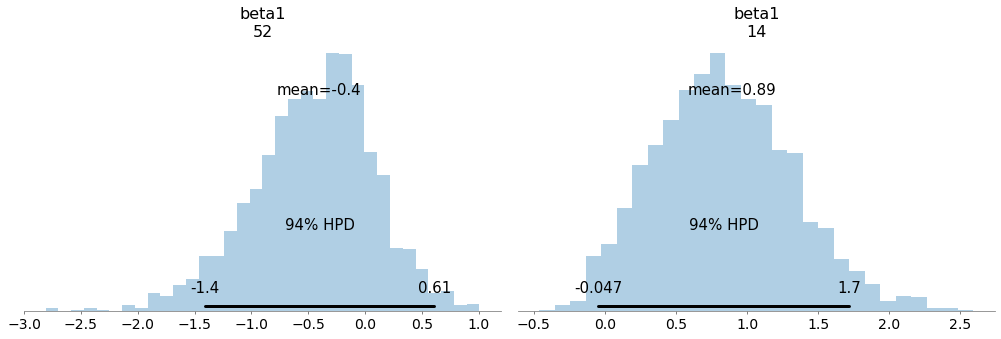

In [29]:
pm.plot_posterior(trace, var_names='beta1', coords={'beta1_dim_0': [52, 14]}, kind='hist')


(<Figure size 1440x360 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f7f90da50>],
       dtype=object))

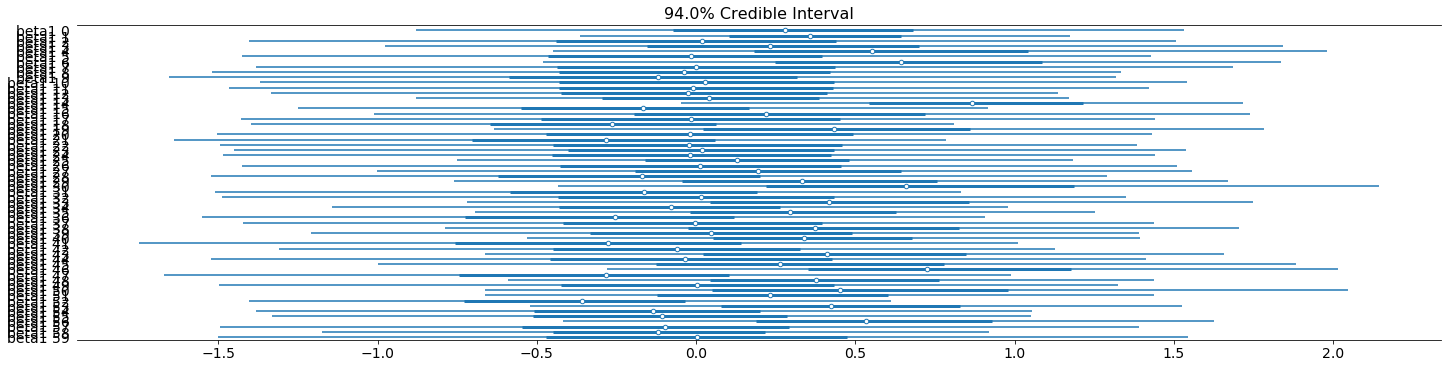

In [30]:
pm.plot_forest(trace,
               kind='forestplot',
               var_names=['beta1'],
               combined=True,
               ridgeplot_overlap=60,
               figsize=(20, 5))


In [31]:
beta2_sum = pm.summary(trace, var_names=['beta2'])
beta2_sum[(beta2_sum['mean']==beta2_sum['mean'].min()) | (beta2_sum['mean']==beta2_sum['mean'].max())]


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta2[27],-0.064,0.114,-0.332,0.092,0.027,0.019,18.0,18.0,23.0,61.0,1.08
beta2[30],0.093,0.129,-0.075,0.368,0.037,0.027,12.0,12.0,14.0,82.0,1.09


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f7a93a550>,
      dtype=object)

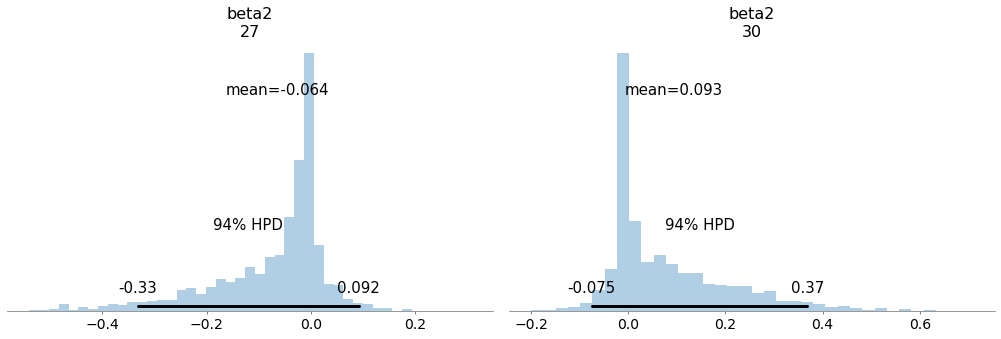

In [32]:
pm.plot_posterior(trace, var_names='beta2', coords={'beta2_dim_0': [27, 30]}, kind='hist')


(<Figure size 1440x360 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f7cb98e10>],
       dtype=object))

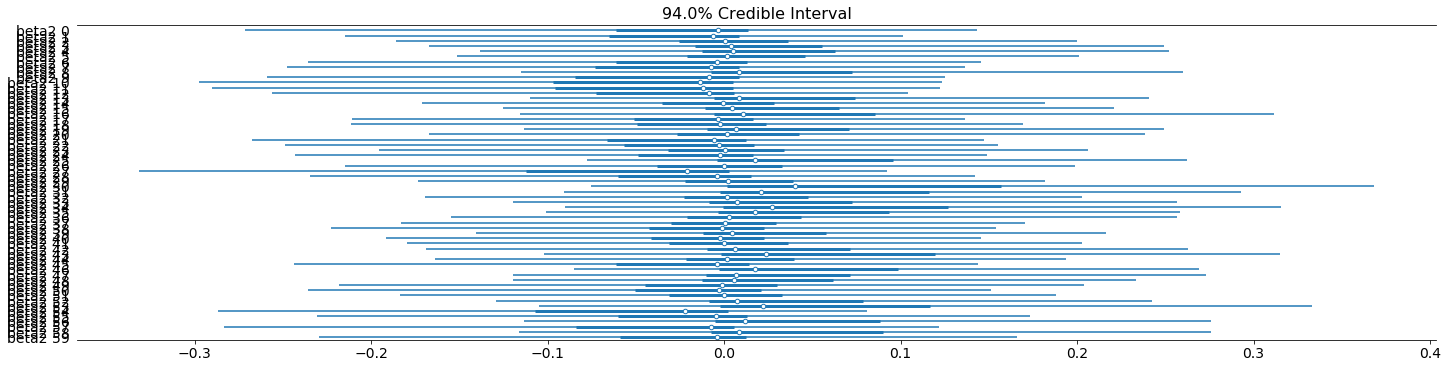

In [33]:
pm.plot_forest(trace,
               kind='forestplot',
               var_names=['beta2'],
               combined=True,
               ridgeplot_overlap=60,
               figsize=(20, 5))


In [34]:
beta3_sum = pm.summary(trace, var_names=['beta3'])
beta3_sum[(beta3_sum['mean']==beta3_sum['mean'].min()) | (beta3_sum['mean']==beta3_sum['mean'].max())]


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta3[18],-0.004,0.013,-0.033,0.018,0.001,0.001,90.0,62.0,170.0,132.0,1.09
beta3[25],0.005,0.013,-0.014,0.033,0.002,0.001,60.0,60.0,96.0,116.0,1.08
beta3[51],-0.004,0.012,-0.030,0.017,0.001,0.001,84.0,69.0,166.0,129.0,1.07
beta3[54],-0.004,0.012,-0.028,0.017,0.001,0.001,72.0,62.0,197.0,80.0,1.08


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f7e200310>,
      dtype=object)

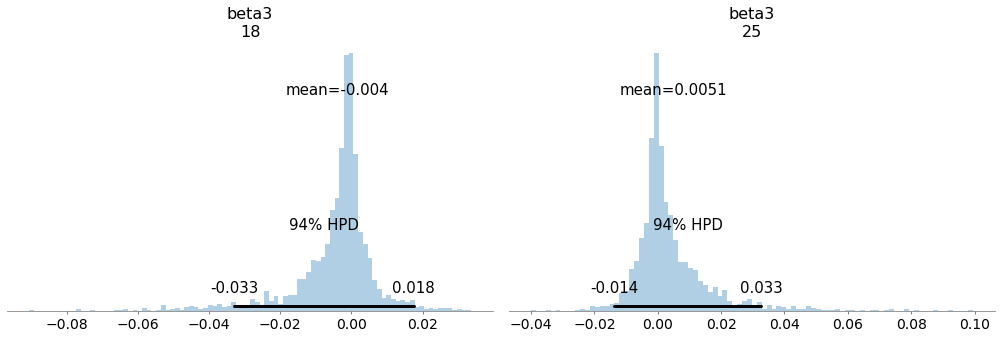

In [35]:
pm.plot_posterior(trace, var_names='beta3', coords={'beta3_dim_0': [18, 25]}, kind='hist')


(<Figure size 1440x360 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f7f333890>],
       dtype=object))

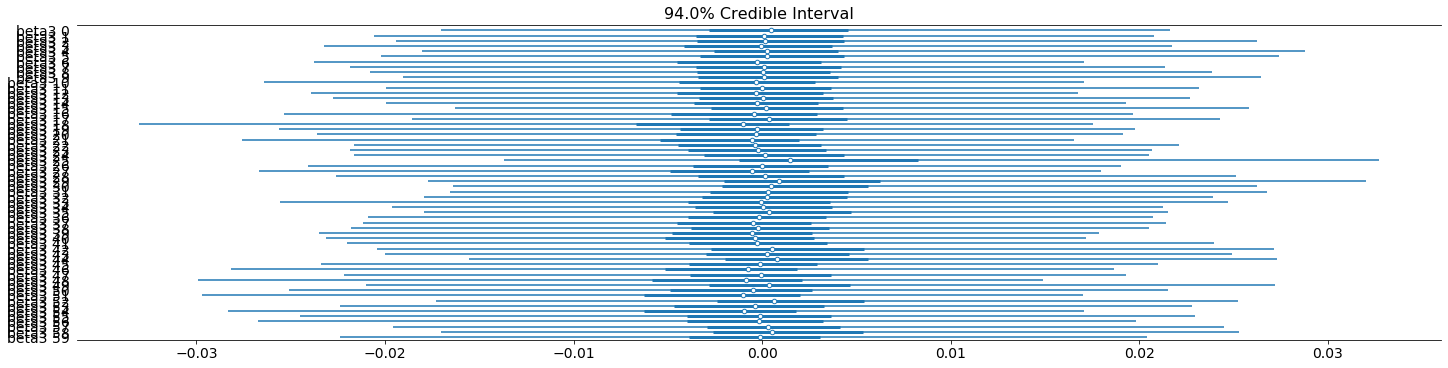

In [36]:
pm.plot_forest(trace,
               kind='forestplot',
               var_names=['beta3'],
               combined=True,
               ridgeplot_overlap=60,
               figsize=(20, 5))


your response here<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;">After reviewing all the varying-coefficient we can see that $beta0$ and $beta1$ vary by district because the coefficients are different and non-zero. The varying coefficients for $beta2$ and $beta3$ are very similar and close to 0. This may imply women who live in certain districts and in urban areas has a varying effect. As a result we will use varying coefficients on $beta0$ and $beta1$ when training our model using the training data then use the model to predict on the test data.</p>
<p style="text-indent: 25px;"></p>
</font>

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Qb1
</span></div>
<div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>rhat values are very high, does not seem like convergence is met
</span></div>
<div class='alert alert-block alert-danger'><b>Deduction : </b><span style = 'color:black'>-3</span></div></div>

##### **B2**

Use all of the information you've gleaned thus far to build a final Bayesian logistic regression classifier on the train set. Then, use your model to make predictions on the test set. Report your model's classification percentage.

In [37]:
#your code here
with pm.Model() as contraceptive_model:
    district = pm.Data('district', train_df['district'])
    urban = pm.Data('urban', train_df['urban'])
    living_children = pm.Data('living_children', train_df['living_children'])
    age_mean = pm.Data('age_mean', train_df['age_mean'])
    contraceptive_use = pm.Data('contraceptive_use', train_df['contraceptive_use'])
    
    mu = pm.Normal('mu', mu=0, sigma=10000)
    
    sigma0 = pm.Gamma('sigma0', alpha=.1, beta=.1)
    sigma1 = pm.Gamma('sigma1', alpha=.1, beta=.1)
    
    beta0 = pm.Normal('beta0', mu=mu, sigma=sigma0, shape=len(np.unique(train_df['district'])))[train_df['district']]
    beta1 = pm.Normal('beta1', mu=0, sigma=sigma1, shape=len(np.unique(train_df['district'])))[train_df['district']]
    beta2 = pm.Normal('beta2', mu=0, sigma=10000)
    beta3 = pm.Normal('beta3', mu=0, sigma=10000)
    
    p_i = pm.Deterministic('$P_i$', pm.math.invlogit(beta0 + beta1*urban + beta2*living_children + beta3*age_mean))
    
    obs = pm.Bernoulli('obs', p=p_i, shape=len(train_df['contraceptive_use']), observed=contraceptive_use)
    
    trace = pm.sample(2000, tune=500, target_accept=0.95)
    
    print(trace.varnames)
    print('DONE')


/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/share/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta3, beta2, beta1, beta0, sigma1, sigma0, mu]
/usr/share/anaconda3/lib/python3

['mu', 'sigma0_log__', 'sigma1_log__', 'beta0', 'beta1', 'beta2', 'beta3', 'sigma0', 'sigma1', '$P_i$']
DONE


In [38]:
with contraceptive_model:
    # Switch out the observations and use `sample_posterior_predictive` to predict
    district.set_value(test_df['district'])
    urban.set_value(test_df['urban'])
    living_children.set_value(test_df['living_children'])
    age_mean.set_value(test_df['age_mean'])
    contraceptive_use.set_value(test_df['contraceptive_use'])
    
    post_pred = pm.sample_posterior_predictive(trace, samples=len(test_df['contraceptive_use']))
    
    print('DONE')


/usr/share/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 967/967 [00:19<00:00, 50.81it/s]

DONE


The true contraceptive use mean is 0.39503619441571874
The predicted contraceptive use mean is 0.44570837642192346


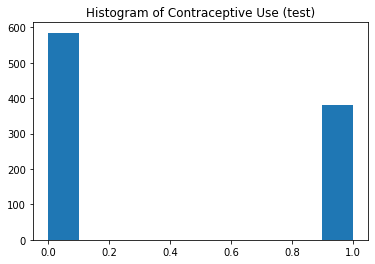

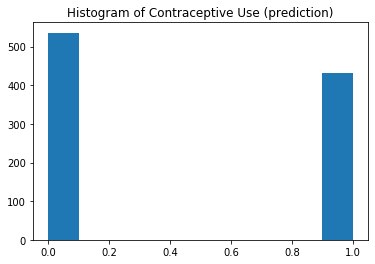

In [39]:
prediction = post_pred['obs'][:,0]
print('The true contraceptive use mean is', test_df['contraceptive_use'].mean())
print('The predicted contraceptive use mean is', prediction.mean())

plt.hist(test_df['contraceptive_use'])
plt.title('Histogram of Contraceptive Use (test)')
plt.show()

plt.hist(prediction)
plt.title('Histogram of Contraceptive Use (prediction)')
plt.show()


your response here<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;">Using the varying coefficient model for $beta0$ and $beta1$ we see that we get a predicted contraceptive use mean of 0.445 versus the actual test contraceptive mean of 0.395, which is very close.</p>
<p style="text-indent: 25px;"></p>
</font>

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Qb2
</span></div>
<div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>No mention of classication rate
</span></div>
<div class='alert alert-block alert-danger'><b>Deduction : </b><span style = 'color:black'>-3</span></div></div>

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#999; background:#fff;">
Graded by: Robbert Struyven
</footer>